
========== RANSOMWARE FILE ACCESS ==========
Mean: 0.526
Variance: 1.136


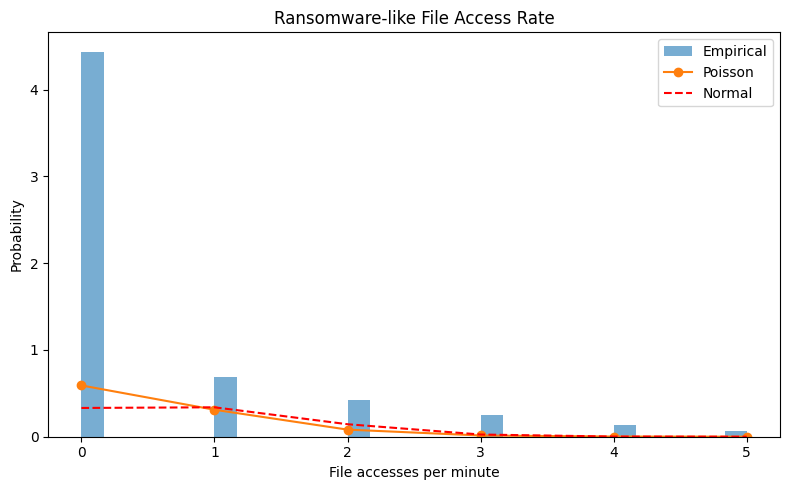


[Ransomware] Poisson Chi-square Test
Estimated λ: 0.526
Chi-square statistic: 767428.959
p-value: 0.0

[Ransomware] KS Test
Poisson KS p-value: 0.0
Normal  KS p-value: 0.0

========== BRUTE-FORCE LOGIN ATTEMPTS ==========
Mean: 7.896
Variance: 58.451


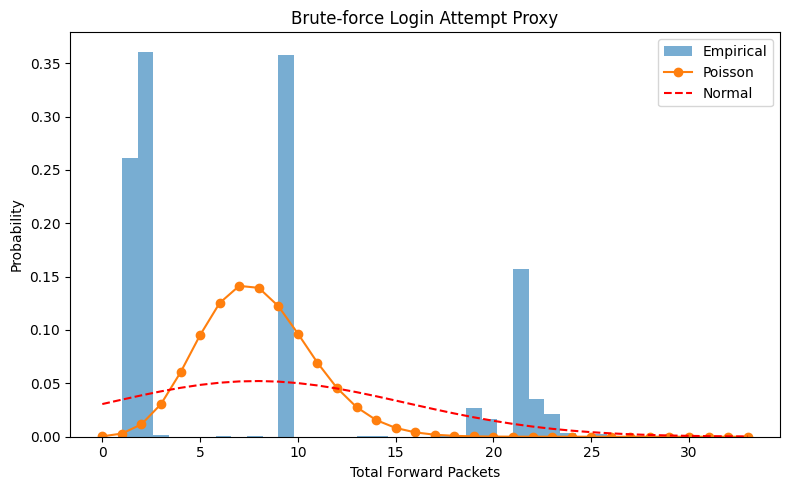


[Brute Force] Poisson Chi-square Test
Estimated λ: 7.896
Chi-square statistic: 388348.429
p-value: 0.0

[Brute Force] KS Test
Poisson KS p-value: 0.0
Normal  KS p-value: 0.0


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# =========================================================
# HELPER: POISSON CHI-SQUARE TEST (CORRECTED)
# =========================================================
def poisson_chi_square_test(data, label=""):
    data = data.astype(int)
    lambda_hat = data.mean()

    obs_counts = np.bincount(data)
    k = np.arange(len(obs_counts))

    expected_probs = stats.poisson.pmf(k, lambda_hat)
    expected_counts = expected_probs * len(data)

    # Remove bins with low expected frequency
    mask = expected_counts >= 5

    obs = obs_counts[mask]
    exp = expected_counts[mask]

    # 🔑 CRITICAL FIX: Renormalize expected frequencies
    exp = exp * obs.sum() / exp.sum()

    chi2, p = stats.chisquare(obs, exp)

    print(f"\n[{label}] Poisson Chi-square Test")
    print("Estimated λ:", round(lambda_hat, 3))
    print("Chi-square statistic:", round(chi2, 3))
    print("p-value:", round(p, 5))

    return chi2, p


# =========================================================
# 1️⃣ RANSOMWARE FILE ACCESS (CERT DATASET)
# =========================================================
print("\n========== RANSOMWARE FILE ACCESS ==========")

cert = pd.read_csv("../data/file.csv", low_memory=False)
cert.columns = cert.columns.str.strip()

# CERT uses 'date', not 'timestamp'
cert["date"] = pd.to_datetime(cert["date"])

file_rate = (
    cert
    .set_index("date")
    .resample("1min")
    .size()
)

# Remove extreme outliers (optional but recommended)
file_rate = file_rate[file_rate < file_rate.quantile(0.99)]

data_rw = file_rate.values

print("Mean:", round(data_rw.mean(), 3))
print("Variance:", round(data_rw.var(), 3))

# Histogram + fits
plt.figure(figsize=(8, 5))
plt.hist(data_rw, bins=30, density=True, alpha=0.6, label="Empirical")

x = np.arange(0, data_rw.max() + 1)
plt.plot(x, stats.poisson.pmf(x, data_rw.mean()), "o-", label="Poisson")
plt.plot(x, stats.norm.pdf(x, data_rw.mean(), data_rw.std()), "r--", label="Normal")

plt.title("Ransomware-like File Access Rate")
plt.xlabel("File accesses per minute")
plt.ylabel("Probability")
plt.legend()
plt.tight_layout()
plt.show()

# Tests
poisson_chi_square_test(data_rw, label="Ransomware")

ks_poisson_rw = stats.kstest(
    data_rw, lambda x: stats.poisson.cdf(x, data_rw.mean())
)
ks_normal_rw = stats.kstest(
    data_rw, lambda x: stats.norm.cdf(x, data_rw.mean(), data_rw.std())
)

print("\n[Ransomware] KS Test")
print("Poisson KS p-value:", round(ks_poisson_rw.pvalue, 5))
print("Normal  KS p-value:", round(ks_normal_rw.pvalue, 5))


# =========================================================
# 2️⃣ BRUTE-FORCE LOGIN ATTEMPTS (CICIDS-2017)
# =========================================================
print("\n========== BRUTE-FORCE LOGIN ATTEMPTS ==========")

cic = pd.read_csv(
    "../data/Tuesday-WorkingHours.pcap_ISCX.csv",
    low_memory=False
)
cic.columns = cic.columns.str.strip()

bf = cic[cic["Label"].str.contains("Patator|Brute", case=False, na=False)]

# Proxy for login attempts
bf_attempts = bf["Total Fwd Packets"].dropna().astype(int)

# 🔑 SAFE SAMPLING (NO ERRORS)
bf_attempts = bf_attempts.sample(
    n=min(200_000, len(bf_attempts)),
    random_state=42
)

print("Mean:", round(bf_attempts.mean(), 3))
print("Variance:", round(bf_attempts.var(), 3))

# Histogram + fits
plt.figure(figsize=(8, 5))
plt.hist(bf_attempts, bins=40, density=True, alpha=0.6, label="Empirical")

x = np.arange(0, bf_attempts.max() + 1)
plt.plot(x, stats.poisson.pmf(x, bf_attempts.mean()), "o-", label="Poisson")
plt.plot(
    x,
    stats.norm.pdf(x, bf_attempts.mean(), bf_attempts.std()),
    "r--",
    label="Normal"
)

plt.title("Brute-force Login Attempt Proxy")
plt.xlabel("Total Forward Packets")
plt.ylabel("Probability")
plt.legend()
plt.tight_layout()
plt.show()

# Tests
poisson_chi_square_test(bf_attempts, label="Brute Force")

ks_poisson_bf = stats.kstest(
    bf_attempts, lambda x: stats.poisson.cdf(x, bf_attempts.mean())
)
ks_normal_bf = stats.kstest(
    bf_attempts, lambda x: stats.norm.cdf(x, bf_attempts.mean(), bf_attempts.std())
)

print("\n[Brute Force] KS Test")
print("Poisson KS p-value:", round(ks_poisson_bf.pvalue, 5))
print("Normal  KS p-value:", round(ks_normal_bf.pvalue, 5))
